In [1]:
using ForneyLab
using PyPlot

n = 20

g = FactorGraph()

# Specify model
m_1 ~ GaussianMeanVariance(constant(0.05), constant(100.0))
w_1 ~ Gamma(constant(0.01), constant(0.01))
m_2 ~ GaussianMeanVariance(constant(-0.05), constant(100.0))
w_2 ~ Gamma(constant(0.01), constant(0.01))

z = Vector{Variable}(n)
for i = 1:n
    z[i] ~ Bernoulli(constant(0.5))
    y_i ~ GaussianMixture(m_1, w_1, m_2, w_2, z[i])
    placeholder(y_i, :y, index=i)
    z[i].id = :z_*i
    y_i.id = :y_*i
end

# Assign ids for easy lookup
m_1.id = :m_1
w_1.id = :w_1
m_2.id = :m_2
w_2.id = :w_2
;

In [2]:
rf = RecognitionFactorization()

# Specify recognition factorization
q_m_1 = RecognitionFactor(m_1)
q_w_1 = RecognitionFactor(w_1)
q_m_2 = RecognitionFactor(m_2)
q_w_2 = RecognitionFactor(w_2)
q_z = RecognitionFactor(z)
;

In [3]:
# Generate Julia algorithm code
algo_q_m_1 = messagePassingAlgorithm(variationalSchedule(q_m_1), m_1, name="M1")
algo_q_w_1 = messagePassingAlgorithm(variationalSchedule(q_w_1), w_1, name="W1")
algo_q_m_2 = messagePassingAlgorithm(variationalSchedule(q_m_2), m_2, name="M2")
algo_q_w_2 = messagePassingAlgorithm(variationalSchedule(q_w_2), w_2, name="W2")
algo_q_z = messagePassingAlgorithm(variationalSchedule(q_z), z, name="Z")
algo_F = freeEnergyAlgorithm()
;

In [4]:
println(algo_q_m_1)

function stepM1!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(40))

messages[1] = ruleVBGaussianMeanVariance3(ProbabilityDistribution(PointMass, m=0.05), ProbabilityDistribution(PointMass, m=100.0), nothing)
messages[2] = ruleVBGaussianMixture1(nothing, marginals[:w_1], marginals[:m_2], marginals[:w_2], marginals[:z_19], ProbabilityDistribution(PointMass, m=data[:y][19]))
messages[3] = ruleVBGaussianMixture1(nothing, marginals[:w_1], marginals[:m_2], marginals[:w_2], marginals[:z_20], ProbabilityDistribution(PointMass, m=data[:y][20]))
messages[4] = ruleSPEqualityGaussian(messages[2], nothing, messages[3])
messages[5] = ruleVBGaussianMixture1(nothing, marginals[:w_1], marginals[:m_2], marginals[:w_2], marginals[:z_18], ProbabilityDistribution(PointMass, m=data[:y][18]))
messages[6] = ruleSPEqualityGaussian(messages[5], nothing, messages[4])
messages[7] = ruleVBGaussianMixture1(nothing, marginals[:w_1], marginals[:m_2], marginals[:w_2], marginals[:z_17], 

In [5]:
# Load algorithms
eval(parse(algo_q_m_1))
eval(parse(algo_q_w_1))
eval(parse(algo_q_m_2))
eval(parse(algo_q_w_2))
eval(parse(algo_q_z))
eval(parse(algo_F))
;

In [6]:
# Generate toy dataset
y = Vector{Float64}(n)
m_1_true = -1.0
w_1_true = 0.5
m_2_true = 1.0
w_2_true = 2.0

z_true = rand(n)
for i = 1:n
    if z_true[i] > 0.5
        y[i] = sqrt(1/w_1_true)*randn() + m_1_true
    else
        y[i] = sqrt(1/w_2_true)*randn() + m_2_true
    end
end
data = Dict(:y => y)

# Prepare recognition distributions
marginals = Dict(:m_1 => vague(ProbabilityDistribution{Gaussian}),
                 :w_1 => vague(ProbabilityDistribution{Gamma}),
                 :m_2 => vague(ProbabilityDistribution{Gaussian}),
                 :w_2 => vague(ProbabilityDistribution{Gamma}))
for i = 1:n
    marginals[:z_*i] = vague(ProbabilityDistribution{Bernoulli})
end

# Execute algorithm
n_its = 2*n
F = Vector{Float64}(n_its)
for i = 1:n_its
    stepM1!(data, marginals)
    stepW1!(data, marginals)
    stepM2!(data, marginals)
    stepW2!(data, marginals)
    stepZ!(data, marginals)
    F[i] = freeEnergy(data, marginals)
end

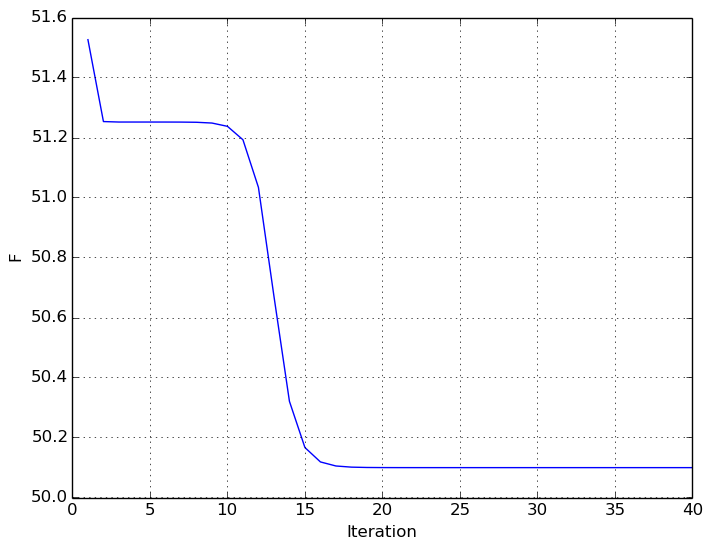

PyObject <matplotlib.text.Text object at 0x7fdf4befac10>

In [7]:
# Plot free energy to check for convergence
plot(1:n_its, F)
grid("on")
xlabel("Iteration")
ylabel("F")

In [8]:
# Inspect the results
println("True m_1: $(m_1_true)")
println("True w_1: $(w_1_true)")
println("True m_2: $(m_2_true)")
println("True w_2: $(w_2_true)")
println("Number of samples: $(n)")
println("Sample m_1: $(round(mean(y[z_true .> 0.5]),2))")
println("Sample w_1: $(round(1/var(y[z_true .> 0.5]),2))")
println("Sample m_2: $(round(mean(y[z_true .<= 0.5]),2))")
println("Sample w_2: $(round(1/var(y[z_true .<= 0.5]),2))")
println("\n----- Estimates after $(n_its) VMP updates -----")
println("m_1 estimate: $(round(mean(marginals[:m_1]),2)), with variance $(round(var(marginals[:m_1]),2))")
println("w_1 estimate: $(round(mean(marginals[:w_1]),2)), with variance $(round(var(marginals[:w_1]),2))")
println("m_2 estimate: $(round(mean(marginals[:m_2]),2)), with variance $(round(var(marginals[:m_2]),2))")
println("w_2 estimate: $(round(mean(marginals[:w_2]),2)), with variance $(round(var(marginals[:w_2]),2))")

True m_1: -1.0
True w_1: 0.5
True m_2: 1.0
True w_2: 2.0
Number of samples: 20
Sample m_1: -0.76
Sample w_1: 0.26
Sample m_2: 0.8
Sample w_2: 1.37

----- Estimates after 40 VMP updates -----
m_1 estimate: 0.67, with variance 0.08
w_1 estimate: 1.14, with variance 0.24
m_2 estimate: -0.24, with variance 0.41
w_2 estimate: 0.27, with variance 0.02
